<a href="https://colab.research.google.com/github/Oumardev/Mask-detection-CNN/blob/main/mask_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import opendatasets as od
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
#!pip install opendatasets

In [ ]:
od.download("https://www.kaggle.com/datasets/omkargurav/face-mask-dataset")

Skipping, found downloaded files in "./face-mask-dataset" (use force=True to force download)


In [ ]:
dimension = 112

In [ ]:
label_names = ['Sans masque','Avec masque']

In [ ]:
def getIndexOfMax(a):
  p_0 = a[0][0]
  p_1 = a[0][1]

  if p_0 > p_1 : return 0
  if p_0 < p_1 : return 0

In [ ]:
def overSampling(images, targets):
  
  images_t = []
  targets_t = []

  for i in range(0,len(targets)):
    t = images[i]
    images_t.append(t)
    targets_t.append(targets[i])

    t_ = cv2.GaussianBlur(images[i],(5,5),10)
    images_t.append(t_)
    targets_t.append(targets[i])

    (h, w) = images[i].shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
    t__ = cv2.warpAffine(images[i], M, (w, h))
    images_t.append(t__)
    targets_t.append(targets[i])

    r = np.arange(0,256)
    c = 255/(np.log(1 + 255))
    y = c*np.log(1+r)
    log_image = c*np.log(images[i]+1)
    log_image = np.array(log_image, dtype=np.uint8)
    t___ = log_image
    images_t.append(t___)
    targets_t.append(targets[i])

  images, targets = shuffle(images_t, targets_t)
        
  return images, targets



In [ ]:
def load_image(dim=256):
    
    with_mask_name =  glob.glob("./face-mask-dataset/data/with_mask/*.jpg")
    without_mask_name =  glob.glob("./face-mask-dataset/data/without_mask/*.jpg")

    frameImg = []
    labelImg = []
    
    for name in with_mask_name:
        img = plt.imread(name)
        nImg = cv2.resize(img, (dim, dim))
        
        if nImg.shape == (dim, dim, 3) :
            frameImg.append(cv2.cvtColor(nImg, cv2.COLOR_BGR2GRAY))
            labelImg.append(1)
        
    for name in without_mask_name:
        img = plt.imread(name)
        nImg = cv2.resize(img, (dim, dim)) 
    
        if nImg.shape == (dim, dim, 3) :
            frameImg.append(cv2.cvtColor(nImg, cv2.COLOR_BGR2GRAY))
            labelImg.append(0)
    
    images, targets = shuffle(frameImg, labelImg)
        
    return images, targets

In [ ]:
images, targets = load_image(dim=dimension)

In [ ]:
#images, targets = overSampling(images, targets)

In [ ]:
images = np.array(images,dtype='uint8')
targets = np.array(targets).reshape(images.shape[0],1)

In [ ]:
print('image shape: ',images.shape)
print('target shape: ',targets.shape)

image shape:  (7544, 112, 112)
target shape:  (7544, 1)


[0]


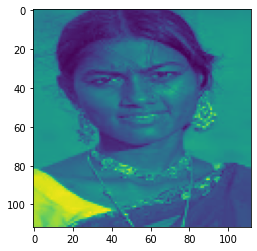

In [ ]:
print(targets[100])
plt.imshow(images[100])

(array([3826.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3718.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

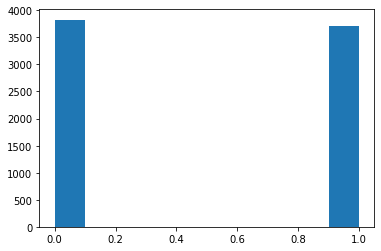

In [ ]:
plt.hist(targets)

In [ ]:
images=np.array(images)/255.0
images=np.reshape(images,(images.shape[0],dimension,dimension,1))

#scaler = StandardScaler()
#images = scaler.fit_transform(images)

#perform one hot encoding 
lb=LabelBinarizer()
labels=lb.fit_transform(targets)
labels=to_categorical(labels)
labels=np.array(labels)
(train_X,test_X,train_y,test_y)=train_test_split(images,labels,test_size=0.25,random_state=0)

#show dimension
print(images.shape)
print(targets.shape)

(7544, 112, 112, 1)
(7544, 1)


In [ ]:
#show dimension
print(train_X.shape)
print(train_y.shape)

(5658, 112, 112, 1)
(5658, 2)


In [ ]:
print(images[0:1].shape)
#Create Model

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=(dimension,dimension,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu",input_shape=(dimension,dimension,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# FLATTERN
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# DENSE LAYERS
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dense(2,activation="softmax"))

model_output = model.predict(train_X[0:1])
print(model_output)

(1, 112, 112, 1)
[[0.49793962 0.5020604 ]]


In [ ]:
#Model summary
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 110, 110, 64)      640       
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 26, 26, 128)      0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 86528)             0         
                                                                 
 dropout_10 (Dropout)        (None, 86528)           

In [ ]:
#Compile the model
#USpr^cA37l1qhZ6q#rZz
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

In [ ]:
train_X.shape

(5658, 112, 112, 1)

In [ ]:
#train model
history = model.fit(train_X,train_y,epochs=50,validation_split=0.25)

Epoch 1/50
133/133 [==============================] - 4s 30ms/step - loss: 0.6864 - accuracy: 0.5515 - val_loss: 0.6733 - val_accuracy: 0.6028
Epoch 2/50
133/133 [==============================] - 4s 29ms/step - loss: 0.6617 - accuracy: 0.6206 - val_loss: 0.6512 - val_accuracy: 0.6346
Epoch 3/50
133/133 [==============================] - 4s 29ms/step - loss: 0.6318 - accuracy: 0.6639 - val_loss: 0.6259 - val_accuracy: 0.6622
Epoch 4/50
133/133 [==============================] - 4s 29ms/step - loss: 0.6043 - accuracy: 0.7070 - val_loss: 0.6099 - val_accuracy: 0.6940
Epoch 5/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5693 - accuracy: 0.7342 - val_loss: 0.5778 - val_accuracy: 0.7180
Epoch 6/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5426 - accuracy: 0.7478 - val_loss: 0.5630 - val_accuracy: 0.7166
Epoch 7/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5190 - accuracy: 0.7650 - val_loss: 0.5326 - val_accuracy: 0.7512

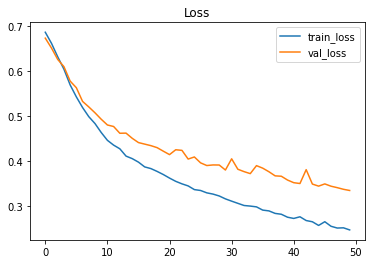

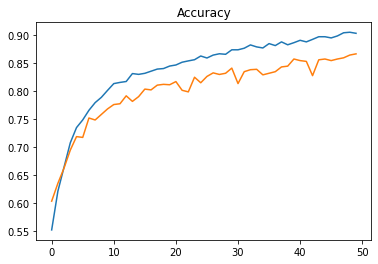

In [ ]:
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]

acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]

plt.plot(loss_curve,label="train_loss")
plt.plot(val_loss_curve,label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(acc_curve,label="train_acc")
plt.plot(val_acc_curve,label="val_acc")
plt.title("Accuracy")
plt.show()

In [ ]:
model.save('mask_detection_cnn.h5')

In [ ]:
# charger le model sauvegardé
loaded_model = tf.keras.models.load_model('./mask_detection_cnn.h5')
loss, acc = loaded_model.evaluate(test_X, test_y)
print("Loss: ",loss)
print("Acc: ",acc)

59/59 [==============================] - 1s 14ms/step - loss: 0.3482 - accuracy: 0.8499
Loss:  0.34815073013305664
Acc:  0.8499469757080078


In [ ]:
text_X_img = test_X.reshape(test_X.shape[0],test_X.shape[1],test_X.shape[2])

[1. 0.]


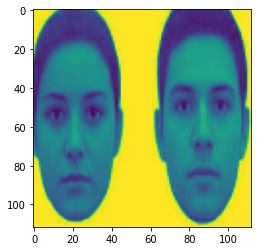

In [ ]:
print(test_y[28])
plt.imshow(text_X_img[28])

In [ ]:
a = loaded_model.predict(test_X[27:28])

In [ ]:
label_names[getIndexOfMax(a)]

'Sans masque'

'Sans masque'

(array([0]), array([0]))